```
This software is a part of GPU Ocean.

Copyright (C) 2024  SINTEF Digital

This notebook is used to make figures that illustrates the double jet case used in the results section of the IEWPF paper.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Checking the double jet case for multi-level applications

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from gpuocean.SWEsimulators import CDKLM16,  ModelErrorKL
from gpuocean.utils import IPythonMagic, DoubleJetCase, PlotHelper

In [3]:
%cuda_context_handler gpu_ctx

In [22]:
ls = [6, 7, 8, 9]

args = [None]*len(ls)
init = [None]*len(ls)

for i in range(len(ls)):
    l = ls[i]
    steadyStateCase = DoubleJetCase.DoubleJetCase(gpu_ctx, model_error=0, ny=2**l, nx=2**(l+1))
    args[i] , init[i], _ = steadyStateCase.getInitConditions()
    

In [28]:
for i in range(len(ls)):
    print('----------- level '+str(ls[i])+' ----------')
    print("(nx, ny)", (args[i]["nx"], args[i]["ny"]))
    print("(dx, dy)", (args[i]["dx"], args[i]["dy"]))
    print("domain size (x, y)", (args[i]["nx"]*args[i]["dx"], args[i]["ny"]*args[i]["dy"]))
    print("(f, g, r)", (args[i]["f"], args[i]["g"], args[i]["r"]))
    print("mean H: ", np.mean(args[i]["H"]), )
    print("max (hu, h): ", np.max(init[i]["hu0"]), np.max(init[i]["hu0"])/np.max(args[i]["H"]))
    print("min (hu, h): ", np.min(init[i]["hu0"]), np.min(init[i]["hu0"])/np.max(args[i]["H"]))
    

----------- level 6 ----------
(nx, ny) (128, 64)
(dx, dy) (10406.25, 10406.25)
domain size (x, y) (1332000.0, 666000.0)
(f, g, r) (0.00014048811587878725, 9.80616, 0.0)
mean H:  227.90106
max (hu, h):  694.6385 3.0479832
min (hu, h):  -677.69556 -2.97364
----------- level 7 ----------
(nx, ny) (256, 128)
(dx, dy) (5203.125, 5203.125)
domain size (x, y) (1332000.0, 666000.0)
(f, g, r) (0.00014048811587878725, 9.80616, 0.0)
mean H:  227.82326
max (hu, h):  696.29565 3.0562975
min (hu, h):  -679.2968 -2.9816833
----------- level 8 ----------
(nx, ny) (512, 256)
(dx, dy) (2601.5625, 2601.5625)
domain size (x, y) (1332000.0, 666000.0)
(f, g, r) (0.00014048811587878725, 9.80616, 0.0)
mean H:  227.78221
max (hu, h):  695.2535 3.052273
min (hu, h):  -678.54596 -2.9789243
----------- level 9 ----------
(nx, ny) (1024, 512)
(dx, dy) (1300.78125, 1300.78125)
domain size (x, y) (1332000.0, 666000.0)
(f, g, r) (0.00014048811587878725, 9.80616, 0.0)
mean H:  227.761
max (hu, h):  694.2769 3.0482678

In [18]:
args[1]["H"]

array([[227.78221, 227.78221, 227.78221, ..., 227.78221, 227.78221,
        227.78221],
       [227.78221, 227.78221, 227.78221, ..., 227.78221, 227.78221,
        227.78221],
       [227.78221, 227.78221, 227.78221, ..., 227.78221, 227.78221,
        227.78221],
       ...,
       [227.78221, 227.78221, 227.78221, ..., 227.78221, 227.78221,
        227.78221],
       [227.78221, 227.78221, 227.78221, ..., 227.78221, 227.78221,
        227.78221],
       [227.78221, 227.78221, 227.78221, ..., 227.78221, 227.78221,
        227.78221]], dtype=float32)

# Run experiments and dump hourly results

In [93]:
start_basis = 1
num_bases = 7
sim_model_error_basis_args = {
                            "basis_x_start": start_basis+1, 
                            "basis_x_end": start_basis+1+num_bases,
                            "basis_y_start": start_basis,
                            "basis_y_end": start_basis+num_bases,

                            "kl_decay": 0.9,
                            "kl_scaling": 0.001,
                            }
T = 13

In [101]:
def run_case():

    steadyStateCase = DoubleJetCase.DoubleJetCase(gpu_ctx, model_error=2, ny=256, nx=512)
    args , init, _ = steadyStateCase.getInitConditions()

    sim = CDKLM16.CDKLM16(**args, **init)
    sim.setKLModelError(**sim_model_error_basis_args)
    sim.model_time_step = 60
    
    t = 0
    T = 13
    allSols = np.zeros((T+1, 3, args['ny'], args['nx']))
    allSols[0, 0, :, :], allSols[0, 1, :, :], allSols[0, 2, :, :] = sim.download(interior_domain_only=True)
    for i in range(T):
        t += 24*3600
        sim.dataAssimilationStep(t)
        print(i)
        allSols[i+1, 0, :, :], allSols[i+1, 1, :, :], allSols[i+1, 2, :, :] = sim.download(interior_domain_only=True)

    return allSols


In [117]:
for a in range(10):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
    allSols = run_case()
    dirname = 'double_jet_ml_output'
    os.makedirs(dirname, exist_ok=True)
    filename = os.path.join(dirname, 'double_jet_'+timestamp+'.npy')
    print(filename)
    np.save(filename, allSols)



0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_04_47.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_06_49.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_08_50.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_10_50.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_12_49.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_14_50.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_16_52.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_18_51.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_20_50.npy
0
1
2
3
4
5
6
7
8
9
10
11
12
double_jet_ml_output\double_jet_2024-02-27T11_22_49.npy


In [137]:
def get_var(i):

    hu_mean = np.zeros((T+1, args["ny"], args["nx"]))
    hu_var  = np.zeros((T+1, args["ny"], args["nx"]))
    N = len(os.listdir(dirname))
    for f in os.listdir(dirname):
        fileSol = np.load(os.path.join(dirname, f))
        hu_mean += fileSol[:, i, :,:]
    hu_mean = hu_mean/N

    for f in os.listdir(dirname):
        fileSol = np.load(os.path.join(dirname, f))
        hu_var += (hu_mean - fileSol[:, i, :,:])**2
    hu_var = np.sqrt(hu_var/(N-1))

    return hu_var, hu_mean, N

hu_var, hu_mean, N = get_var(1)
hv_var, hv_mean, N = get_var(2)
N

100

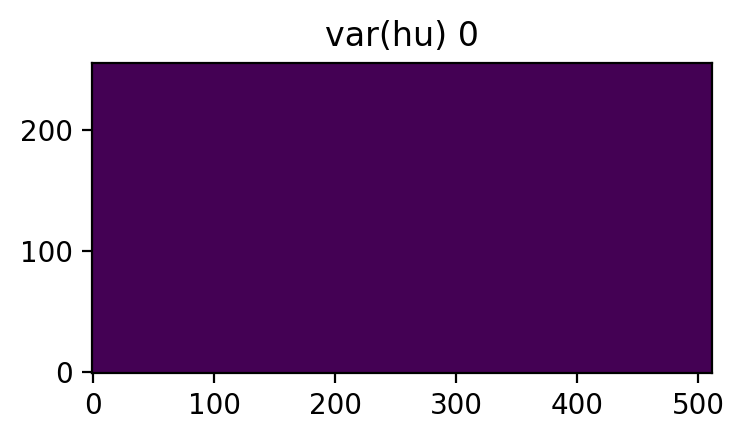

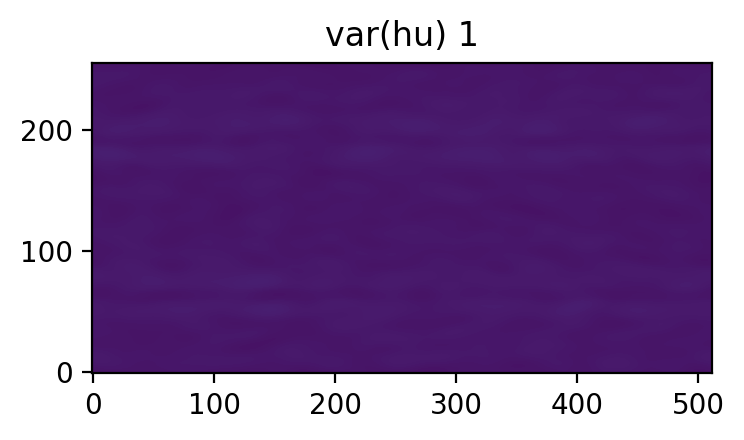

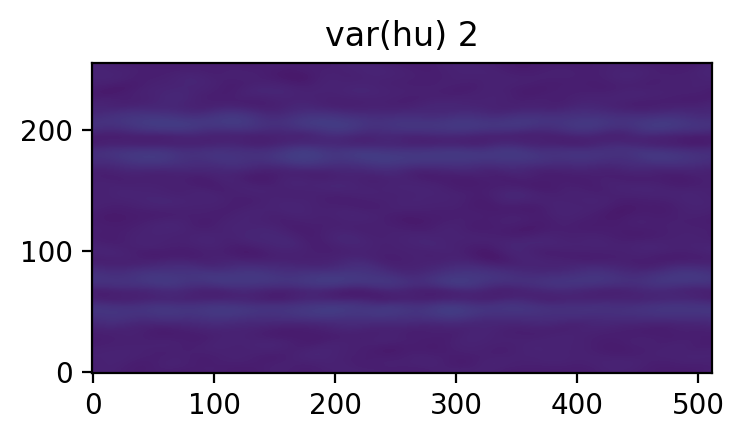

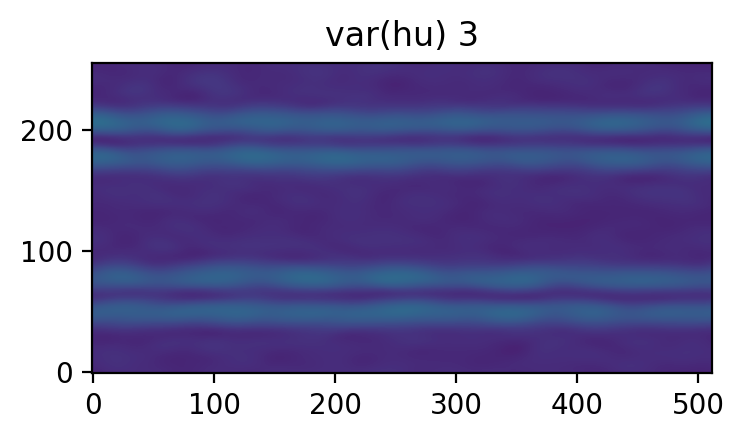

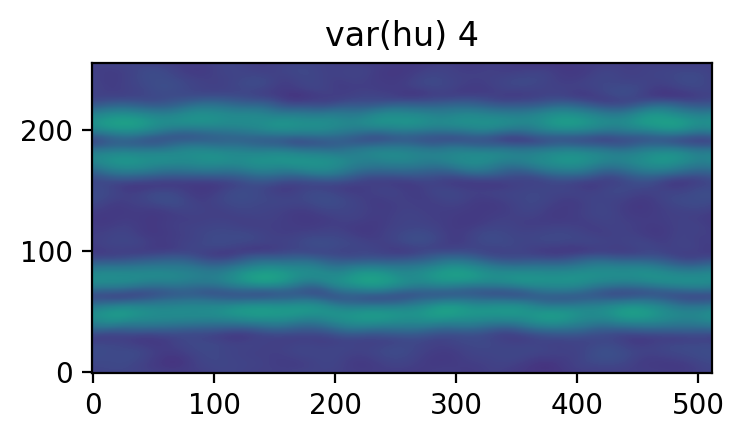

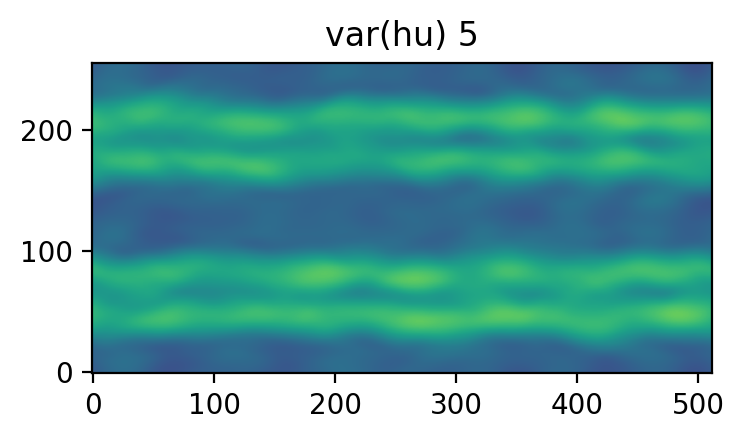

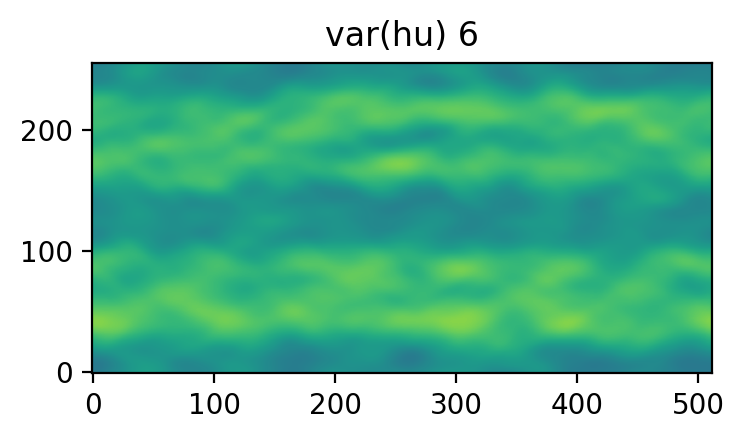

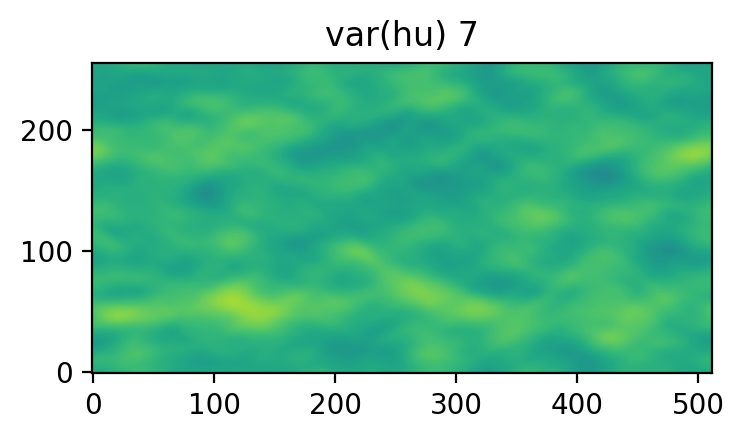

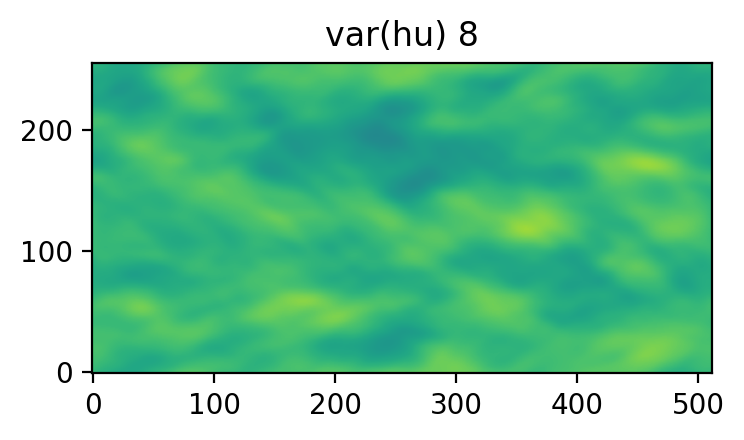

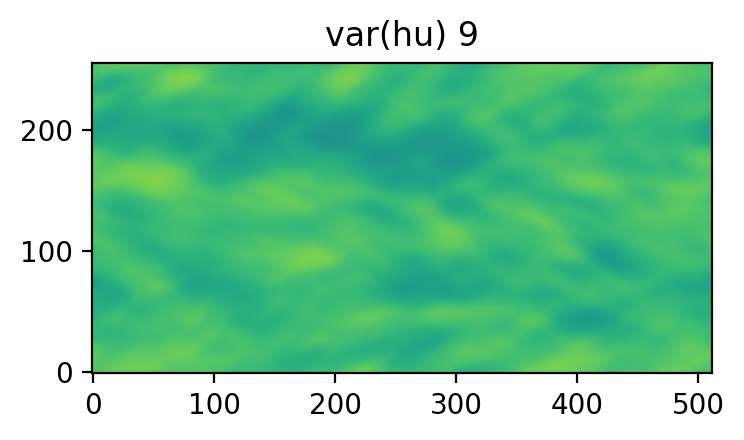

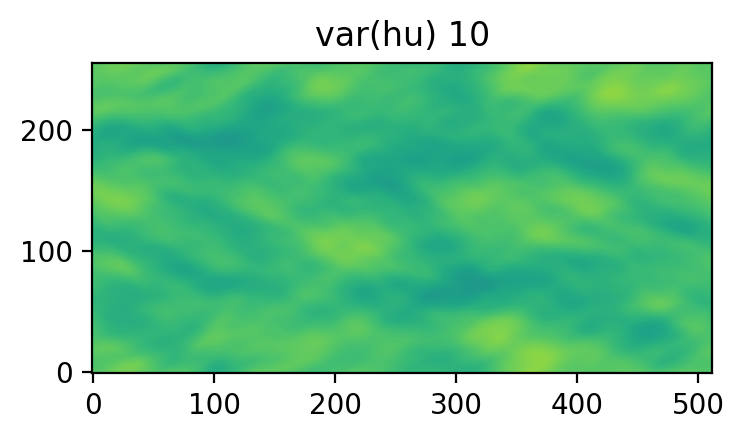

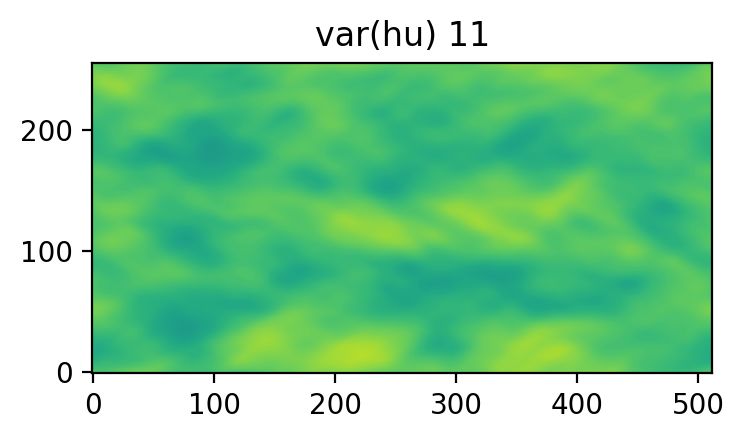

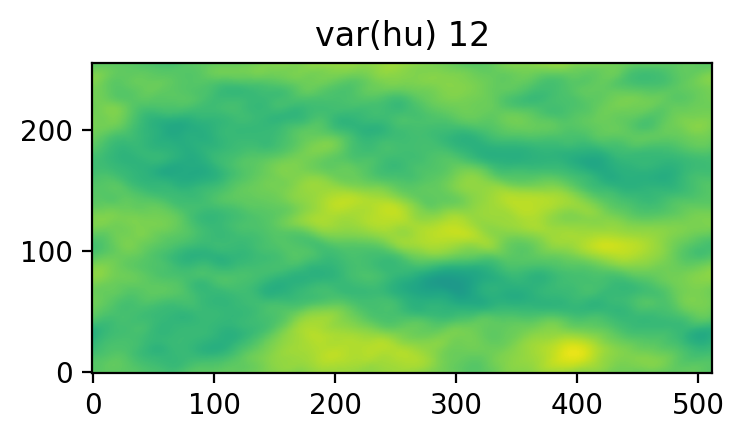

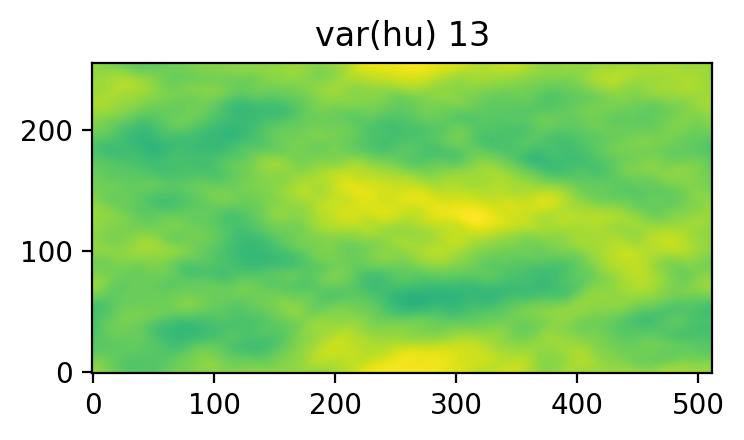

In [138]:
for i in range(T+1):
    fig = plt.figure(figsize=(4,6))
    plt.imshow(hu_var[i], origin='lower', vmax=np.max(hu_var), vmin=0)
    plt.title("var(hu) "+str(i))

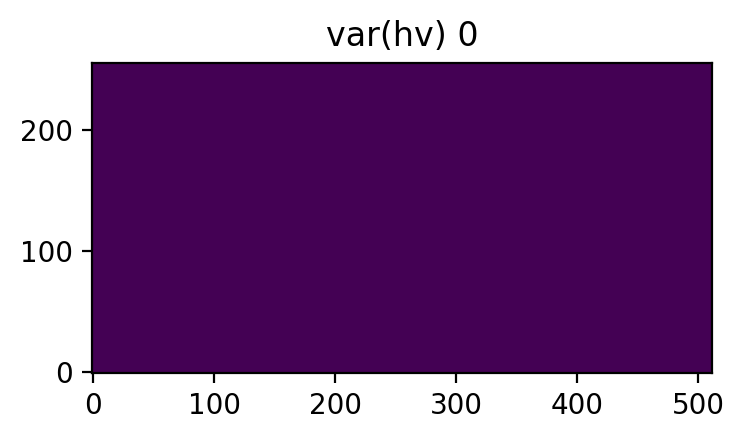

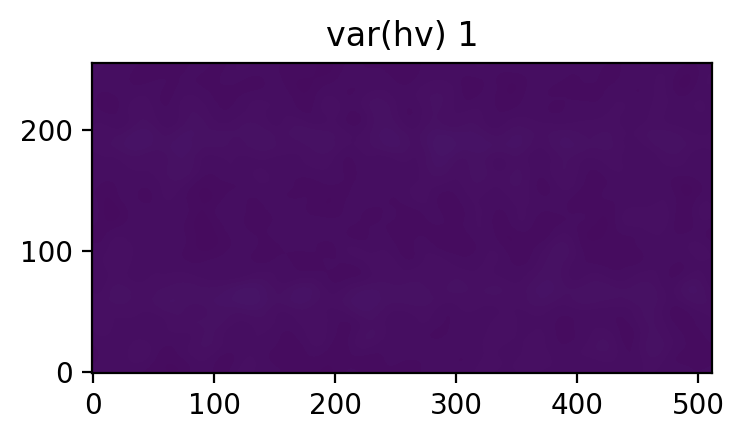

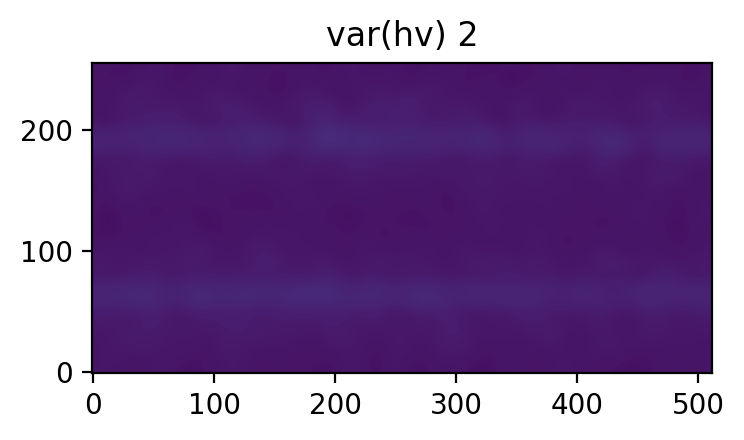

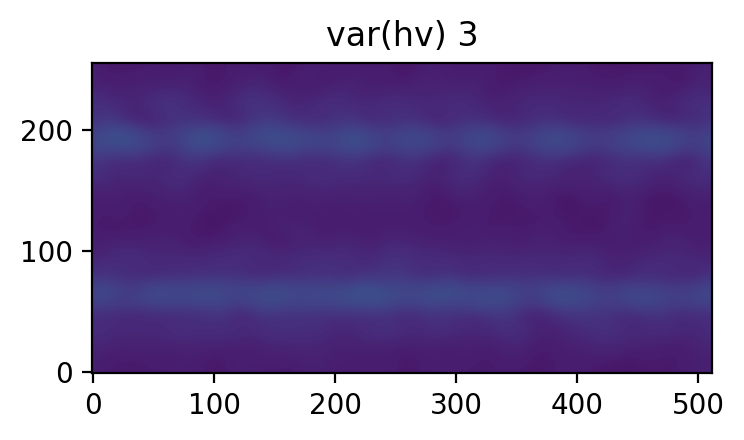

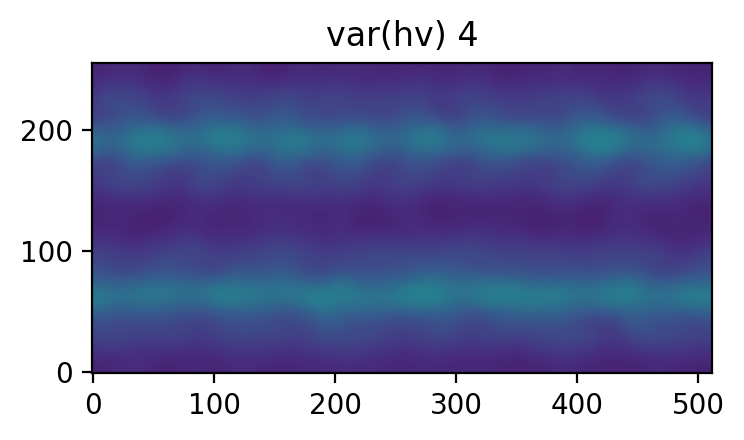

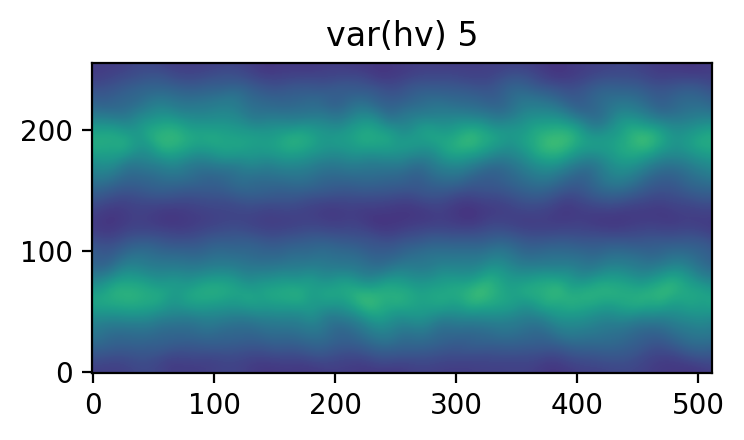

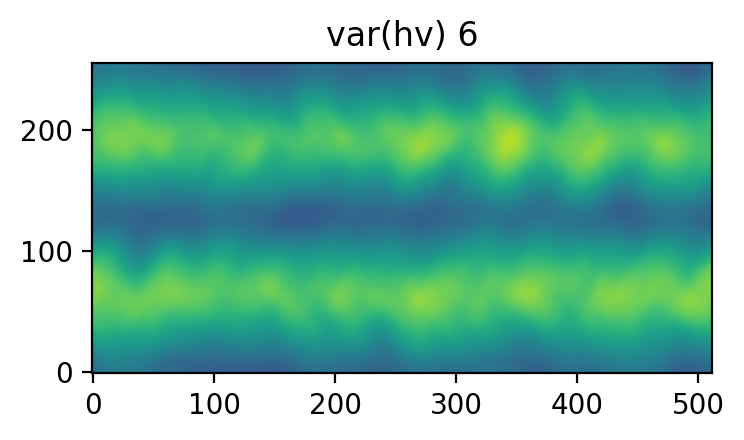

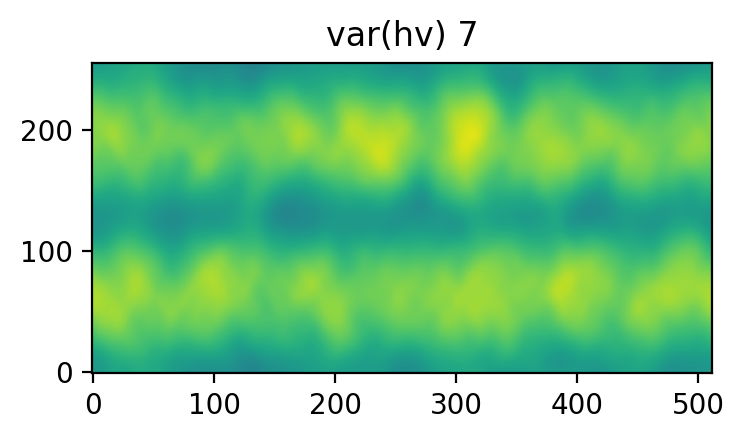

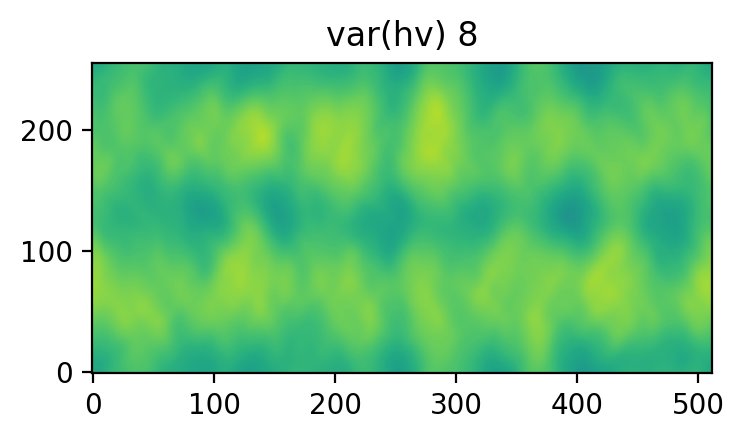

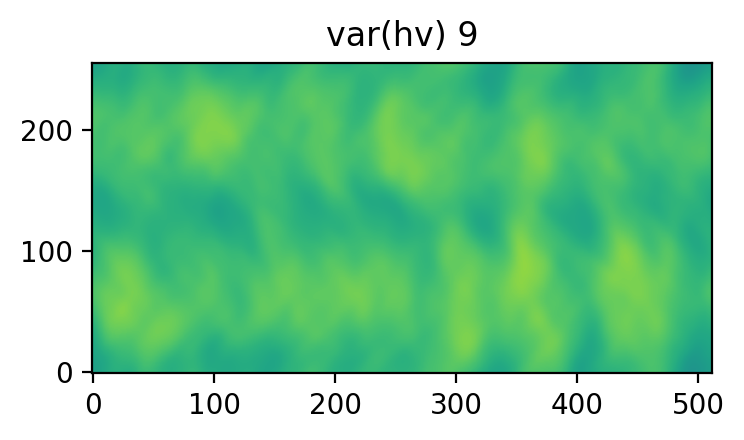

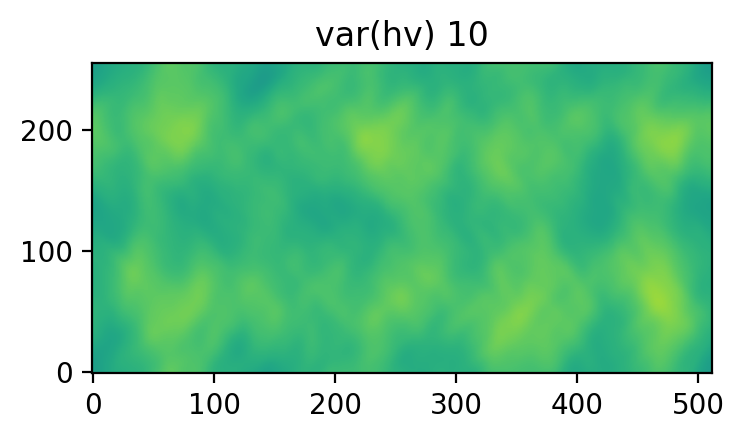

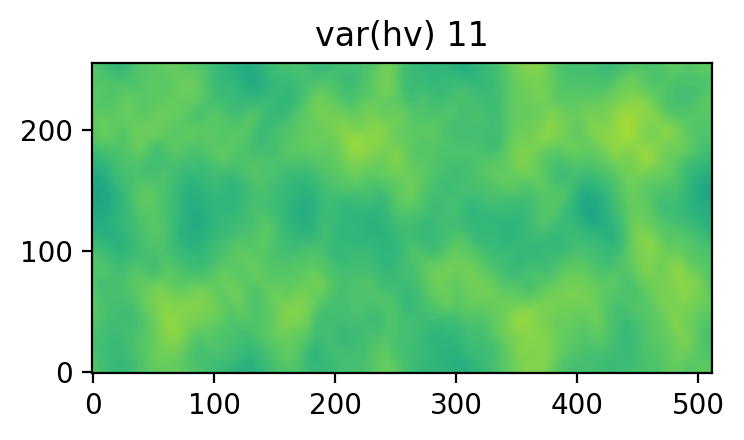

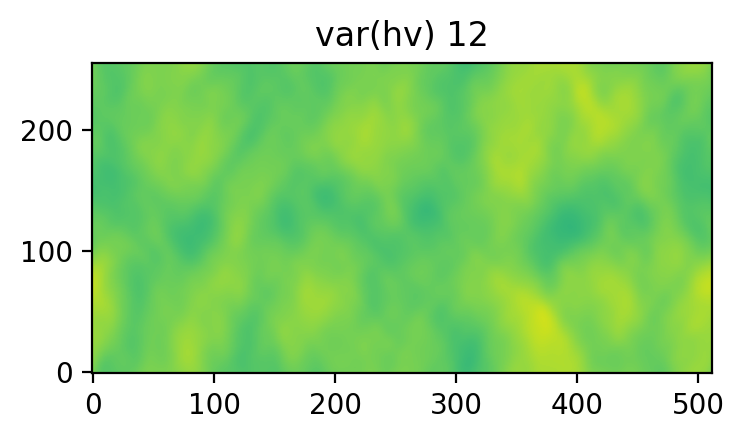

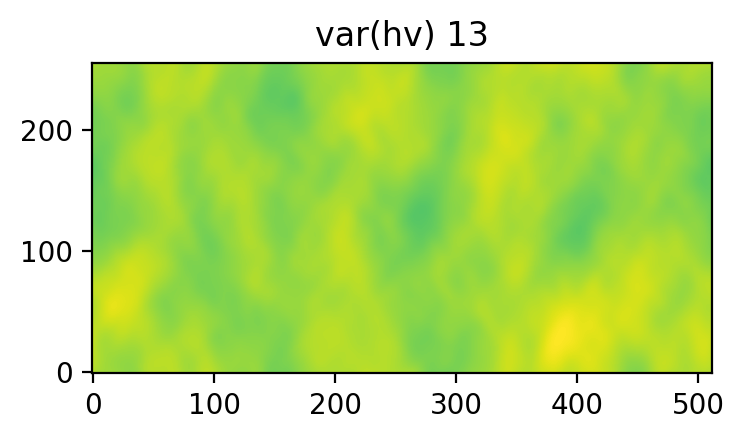

In [139]:
for i in range(T+1):
    fig = plt.figure(figsize=(4,6))
    plt.imshow(hv_var[i], origin='lower', vmax=np.max(hv_var), vmin=0)
    plt.title("var(hv) "+str(i))

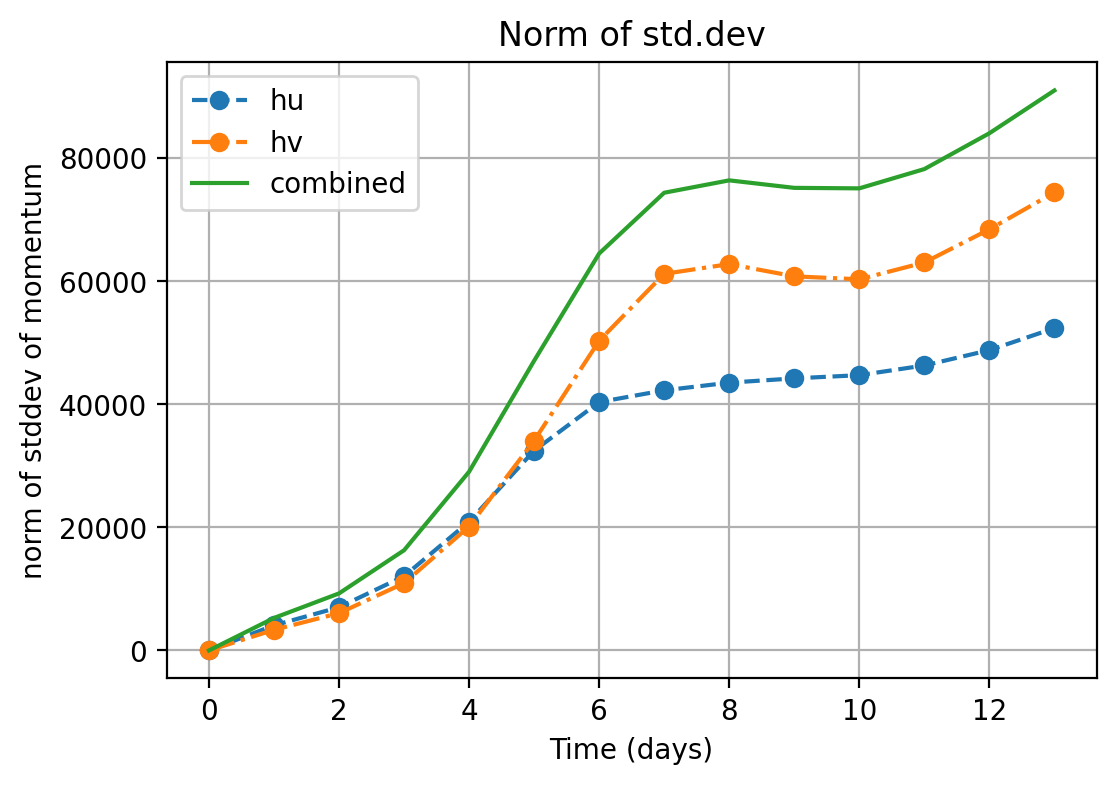

In [141]:
fig = plt.figure(figsize=(6,4))
plt.plot(np.linalg.norm(hu_var, axis=(1,2)), '--o', label='hu')
plt.plot(np.linalg.norm(hv_var, axis=(1,2)), '-.o', label='hv')
combined_norm = np.sqrt(np.linalg.norm(hu_var, axis=(1,2))**2  + np.linalg.norm(hv_var, axis=(1,2))**2)
#plt.plot(combined_norm, label='combined')
plt.title('Norm of std.dev')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('norm of stddev of momentum')
plt.grid()

Text(0, 0.5, 'mean of abs(mean) of momentum')

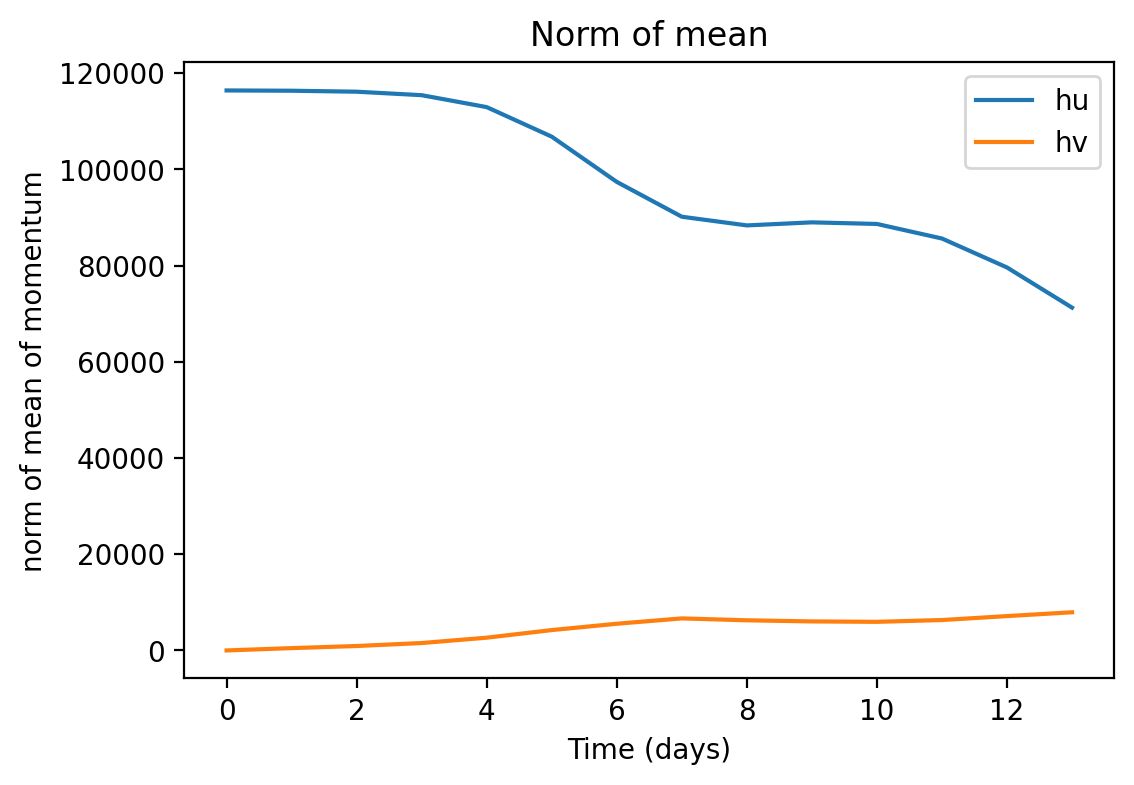

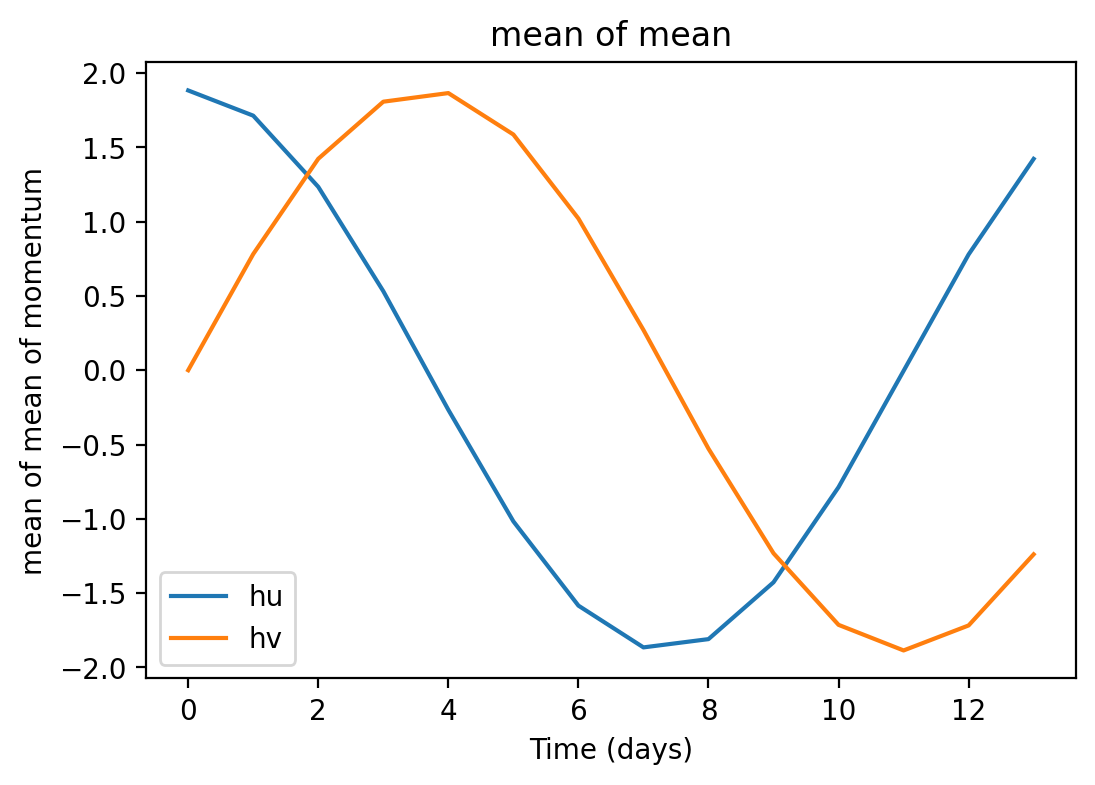

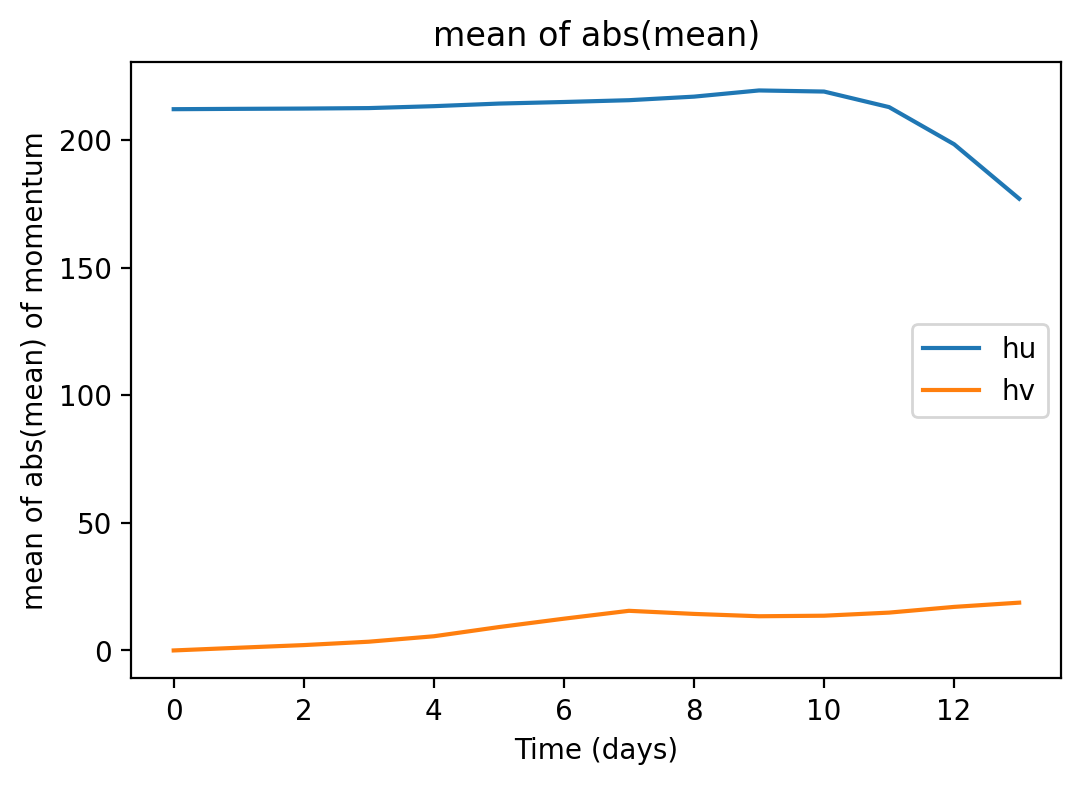

In [142]:
fig = plt.figure(figsize=(6,4))
plt.plot(np.linalg.norm(hu_mean, axis=(1,2)), label='hu')
plt.plot(np.linalg.norm(hv_mean, axis=(1,2)), label='hv')
plt.title('Norm of mean')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('norm of mean of momentum')

fig = plt.figure(figsize=(6,4))
plt.plot(np.mean(hu_mean, axis=(1,2)), label='hu')
plt.plot(np.mean(hv_mean, axis=(1,2)), label='hv')
plt.title('mean of mean')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('mean of mean of momentum')

fig = plt.figure(figsize=(6,4))
plt.plot(np.mean(np.abs(hu_mean), axis=(1,2)), label='hu')
plt.plot(np.mean(np.abs(hv_mean), axis=(1,2)), label='hv')
plt.title('mean of abs(mean)')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('mean of abs(mean) of momentum')


In [129]:
N

100

### Figures for paper

c:\Users\havardh\Miniconda3\envs\gpuocean-extra\lib\site-packages\ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
c:\Users\havardh\Miniconda3\envs\gpuocean-extra\lib\site-packages\ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


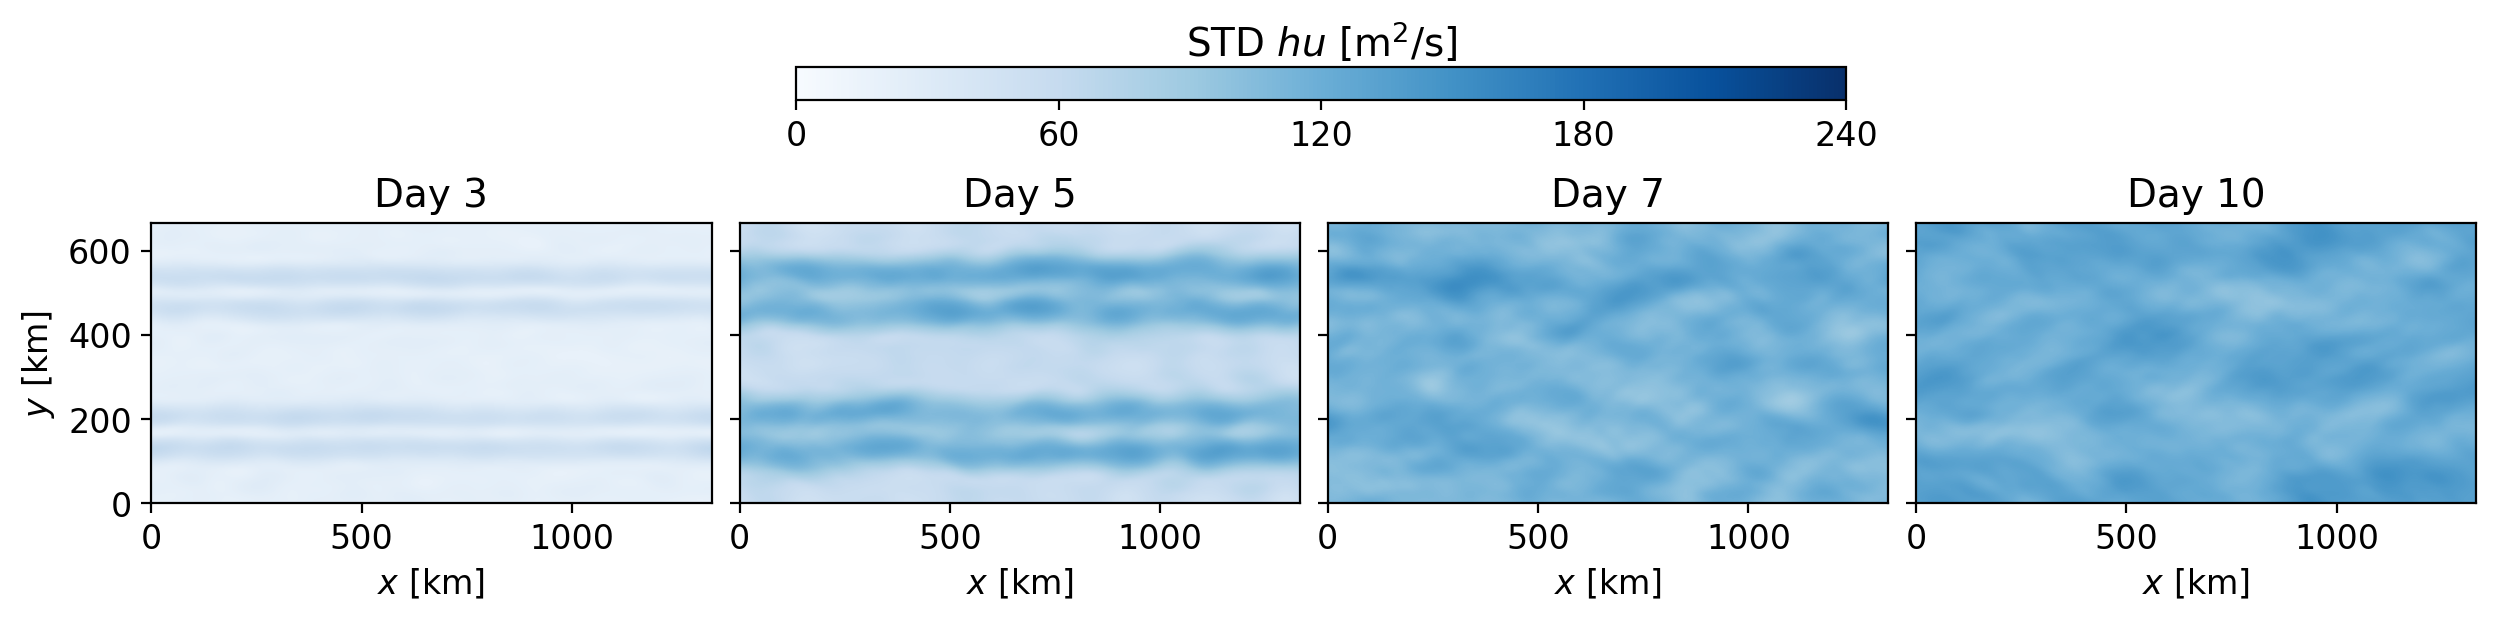

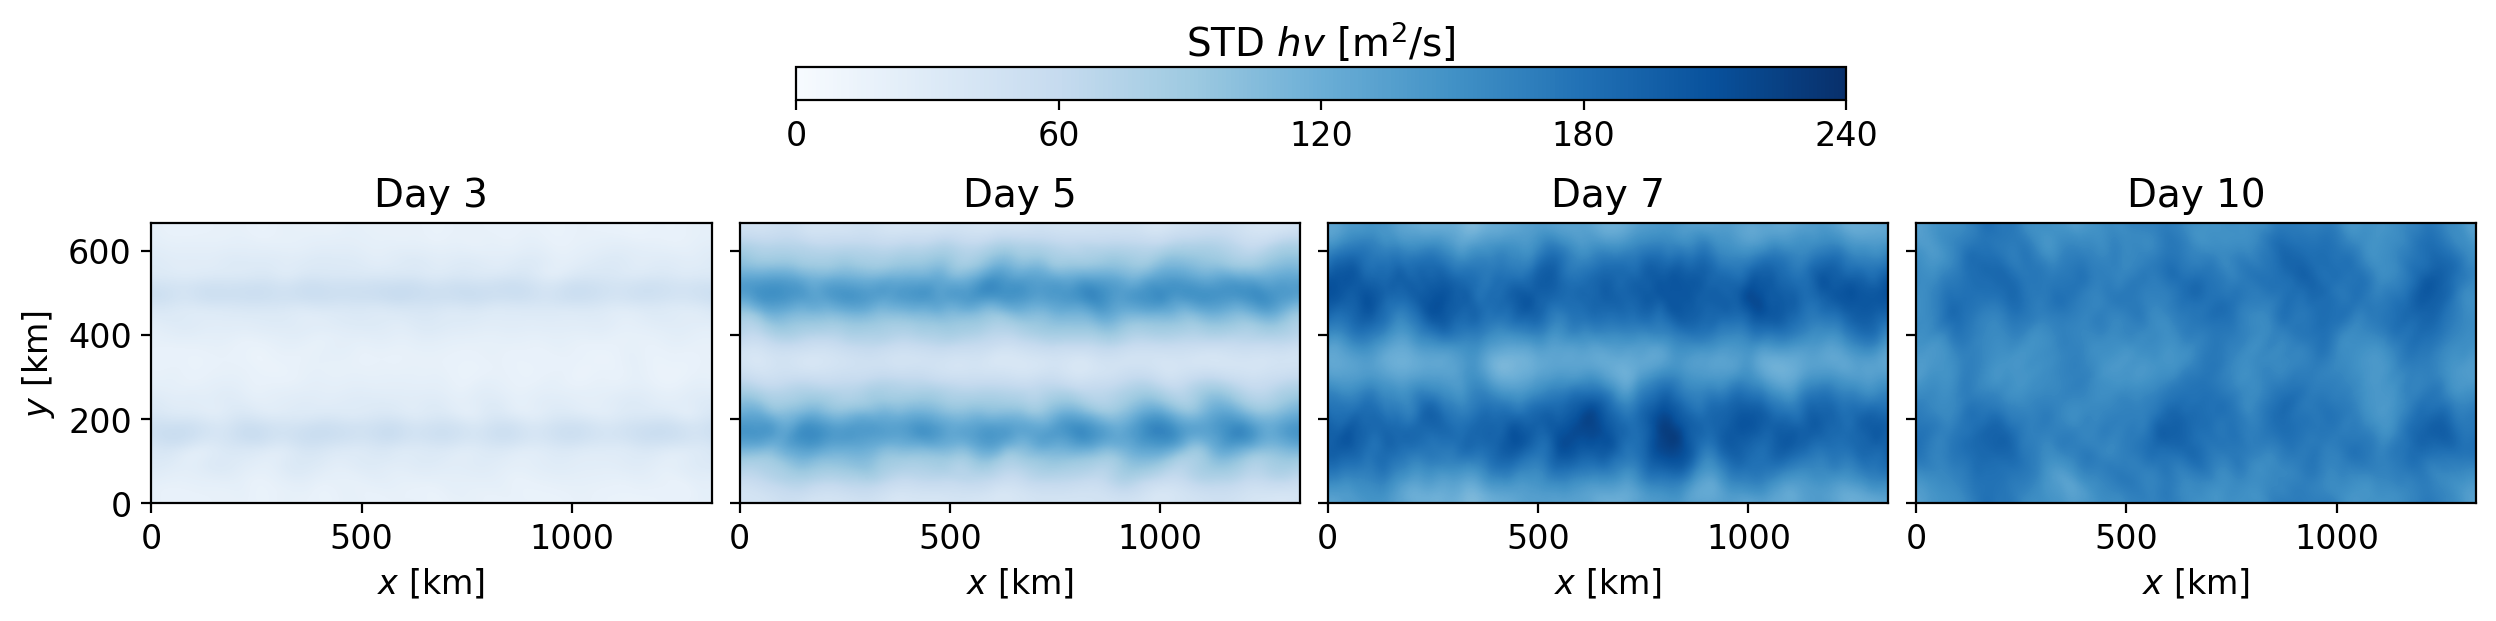

In [171]:
import matplotlib.gridspec as gridspec

def paperStdPlot(full_std_array, cbar_label, filename=None ):
    # Create a grid for subplots
    fig = plt.figure(figsize=(15, 3.25))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], wspace=0.05)

    days = [3, 5, 7, 10]
    std_array = [full_std_array[3], full_std_array[5], full_std_array[7], full_std_array[10]]
    vmax = max(np.max(hu_var), np.max(hv_var))
    std_ticks = np.linspace(0, np.floor(vmax), 5)

    for i in range(len(days)): 
        std = std_array[i]
        
        extent = [0, args["dx"]*args["nx"]/1000, 0, args["dy"]*args["ny"]/1000]

        ax = plt.subplot(gs[i])
        ax.set_title(r"Day "+str(days[i]), fontsize=14)
        ax.set_xlabel(r"$x$ [km]", fontsize=12)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        
        if i>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r"$y$ [km]", fontsize=12)
        im = ax.imshow(std, extent=extent, cmap=plt.cm.Blues, vmin=0.0, vmax=vmax)
        

    cbar_ax = fig.add_axes([0.34, 0.9, 0.35, 0.05])  # Position and dimensions of the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',  ticks=std_ticks)
    cbar.set_label(label=cbar_label, size=14)#, labelpad=-50)

    cbar.ax.xaxis.set_ticks_position('bottom')
    cbar.ax.xaxis.set_label_position('top')

    cbar.ax.tick_params(labelsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename+".pdf", bbox_inches="tight", dpi=300)


paperStdPlot(hu_var, r"STD $hu$ [m$^2$/s]", "mc_std_dev_hu")
paperStdPlot(hv_var, r"STD $hv$ [m$^2$/s]", "mc_std_dev_hv")

In [156]:
def ournorm(field):
    ny, nx = field.shape
    norm = 0.0
    for j in range(ny):
        for i in range(nx):
            norm += field[j,i]**2

    return np.sqrt(args['dx']*args['dy']*norm)

In [157]:
hu_std_norm = [None]*(T+1)
hv_std_norm = [None]*(T+1)
for t in range(T+1):
    hu_std_norm[t] = ournorm(hu_var[t,:, :])
    hv_std_norm[t] = ournorm(hv_var[t,:, :])


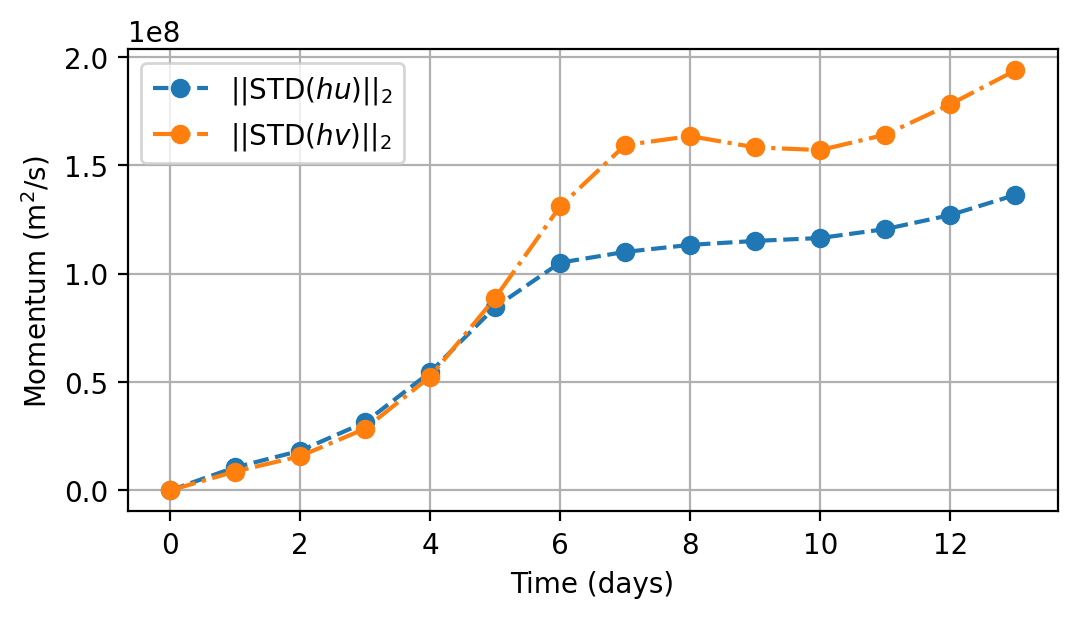

In [170]:
fig = plt.figure(figsize=(6,3))
plt.plot(args['dx']*np.linalg.norm(hu_var, axis=(1,2)), '--o', label=r"$||\mathrm{STD}(hu)||_2$")
plt.plot(args['dx']*np.linalg.norm(hv_var, axis=(1,2)), '-.o', label=r"$||\mathrm{STD}(hv)||_2$")
#plt.plot(hu_std_norm, '--o', label='our hu')
#plt.plot(hv_std_norm, '-.o', label='our hv')
combined_norm = np.sqrt(np.linalg.norm(hu_var, axis=(1,2))**2  + np.linalg.norm(hv_var, axis=(1,2))**2)
#plt.plot(combined_norm, label='combined')
plt.title("")
plt.legend()
plt.xlabel(r"Time (days)")
plt.ylabel(r"Momentum (m$^2$/s)")
plt.grid()
plt.savefig("std_development.pdf", bbox_inches="tight", dpi=300)